In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy

from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/train'
valid_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/valid'
test_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/test'

In [3]:
# ImageDataGenerator generates batches of tensor image data with real-time data augmentation. 
# The data will be looped over (in batches).
# in this example, we won't be doing any image augmentation
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224,224), 
                                                         batch_size=10)

valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(224,224), 
                                                         batch_size=30)

test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(224,224), 
                                                        batch_size=50, 
                                                        shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [4]:
base_model = vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3), pooling='avg')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers[:-13]:
    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
# use “get_layer” method to save the last layer of the network
last_layer = base_model.get_layer('global_average_pooling2d') # the name is diffrent not like -5 and -13

# save the output of the last layer to be the input of the next layer
last_output = last_layer.output

# add our new softmax layer with 3 hidden units
x = Dense(10, activation='softmax', name='softmax')(last_output)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)

# print the new_model summary
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
new_model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
import time
start_time = time.time()
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='signlanguage.model.hdf5', save_best_only=True)

history = new_model.fit_generator(train_batches, steps_per_epoch=18,
                   validation_data=valid_batches, validation_steps=3, epochs=20, verbose=1, callbacks=[checkpointer])
end_time = time.time()
train_time_in_minutes = (end_time - start_time) / 60.0
train_time = end_time - start_time
print(f"Training time: {train_time:.3f} seconds")
print(f"Training time in minutes: {train_time_in_minutes:.3f} minutes")

C:\Users\subeh\AppData\Local\Temp\ipykernel_15096\1835853766.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(train_batches, steps_per_epoch=18,


Epoch 1/20
18/18 [==============================] - 99s 6s/step - loss: 3.2552 - accuracy: 0.1000 - val_loss: 2.2986 - val_accuracy: 0.1222
Epoch 2/20
18/18 [==============================] - 117s 7s/step - loss: 2.2893 - accuracy: 0.1000 - val_loss: 2.3104 - val_accuracy: 0.0667
Epoch 3/20
18/18 [==============================] - 112s 6s/step - loss: 2.3000 - accuracy: 0.0833 - val_loss: 2.3014 - val_accuracy: 0.0889
Epoch 4/20
18/18 [==============================] - 109s 6s/step - loss: 2.3003 - accuracy: 0.0611 - val_loss: 2.3023 - val_accuracy: 0.0444
Epoch 5/20
18/18 [==============================] - 114s 6s/step - loss: 2.2950 - accuracy: 0.0667 - val_loss: 2.2873 - val_accuracy: 0.0889
Epoch 6/20
18/18 [==============================] - 99s 6s/step - loss: 2.2897 - accuracy: 0.0988 - val_loss: 2.2824 - val_accuracy: 0.2444
Epoch 7/20
18/18 [==============================] - 98s 5s/step - loss: 2.2577 - accuracy: 0.1163 - val_loss: 2.3325 - val_accuracy: 0.0444
Epoch 8/20
18/18

In [9]:
def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets

In [10]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

test_files, test_targets = load_dataset('C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/test')

In [11]:
from keras.preprocessing import image  
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image #wrire this to solve the error 'image.load_img'
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 694.91it/s]


In [12]:
new_model.load_weights('signlanguage.model.hdf5')

In [13]:
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*new_model.evaluate(test_tensors, test_targets)))


2/2 [==============================] - 9s 3s/step - loss: 1.1876 - accuracy: 0.5800

Testing loss: 1.1876
Testing accuracy: 0.5800


In [14]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [15]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy

from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
train_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/train'
valid_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/valid'
test_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/test'

In [17]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224,224), 
                                                         batch_size=10)

valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(224,224), 
                                                         batch_size=30)

test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(224,224), 
                                                        batch_size=50, 
                                                        shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [18]:
base_model = vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3), pooling='avg')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
for layer in base_model.layers[:-12]:
    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
last_layer = base_model.get_layer('global_average_pooling2d_1')

# save the output of the last layer to be the input of the next layer
last_output = last_layer.output

# add our new softmax layer with 3 hidden units
x = Dense(10, activation='softmax', name='softmax')(last_output)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)

# print the new_model summary
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [22]:
new_model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
import time
start_time = time.time()
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='signlanguage.model.hdf5', save_best_only=True)

history = new_model.fit_generator(train_batches, steps_per_epoch=18,
                   validation_data=valid_batches, validation_steps=3, epochs=20, verbose=1, callbacks=[checkpointer])
end_time = time.time()
train_time_in_minutes = (end_time - start_time) / 60.0
train_time = end_time - start_time
print(f"Training time: {train_time:.3f} seconds")
print(f"Training time in minutes: {train_time_in_minutes:.3f} minutes")

Epoch 1/20


C:\Users\subeh\AppData\Local\Temp\ipykernel_15096\1835853766.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(train_batches, steps_per_epoch=18,


18/18 [==============================] - 92s 5s/step - loss: 3.6992 - accuracy: 0.1000 - val_loss: 2.3174 - val_accuracy: 0.1444
Epoch 2/20
18/18 [==============================] - 95s 5s/step - loss: 2.2236 - accuracy: 0.1556 - val_loss: 2.1988 - val_accuracy: 0.1556
Epoch 3/20
18/18 [==============================] - 91s 5s/step - loss: 2.2181 - accuracy: 0.1722 - val_loss: 2.1082 - val_accuracy: 0.1556
Epoch 4/20
18/18 [==============================] - 96s 5s/step - loss: 1.9780 - accuracy: 0.1778 - val_loss: 1.8857 - val_accuracy: 0.2444
Epoch 5/20
18/18 [==============================] - 98s 5s/step - loss: 1.9341 - accuracy: 0.2278 - val_loss: 1.8988 - val_accuracy: 0.2667
Epoch 6/20
18/18 [==============================] - 91s 5s/step - loss: 1.9865 - accuracy: 0.2389 - val_loss: 1.8087 - val_accuracy: 0.3222
Epoch 7/20
18/18 [==============================] - 92s 5s/step - loss: 1.8454 - accuracy: 0.2667 - val_loss: 1.7013 - val_accuracy: 0.3333
Epoch 8/20
18/18 [=============

In [24]:
def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets

In [25]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

test_files, test_targets = load_dataset('C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/test')

In [26]:
from keras.preprocessing import image  
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image #wrire this to solve the error 'image.load_img'
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 610.14it/s]


In [27]:
new_model.load_weights('signlanguage.model.hdf5')

In [28]:
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*new_model.evaluate(test_tensors, test_targets)))


2/2 [==============================] - 8s 3s/step - loss: 0.8580 - accuracy: 0.6800

Testing loss: 0.8580
Testing accuracy: 0.6800


In [29]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
#-11

In [30]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy

from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
train_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/train'
valid_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/valid'
test_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/test'

In [32]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224,224), 
                                                         batch_size=10)

valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(224,224), 
                                                         batch_size=30)

test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(224,224), 
                                                        batch_size=50, 
                                                        shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [33]:
base_model = vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3), pooling='avg')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [34]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers[:-11]:
    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [36]:
# use “get_layer” method to save the last layer of the network
last_layer = base_model.get_layer('global_average_pooling2d_2')

# save the output of the last layer to be the input of the next layer
last_output = last_layer.output

# add our new softmax layer with 3 hidden units
x = Dense(10, activation='softmax', name='softmax')(last_output)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)

# print the new_model summary
new_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [37]:
new_model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
import time
start_time = time.time()
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='signlanguage.model.hdf5', save_best_only=True)

history = new_model.fit_generator(train_batches, steps_per_epoch=18,
                   validation_data=valid_batches, validation_steps=3, epochs=20, verbose=1, callbacks=[checkpointer])
end_time = time.time()
train_time_in_minutes = (end_time - start_time) / 60.0
train_time = end_time - start_time
print(f"Training time: {train_time:.3f} seconds")
print(f"Training time in minutes: {train_time_in_minutes:.3f} minutes")

Epoch 1/20


C:\Users\subeh\AppData\Local\Temp\ipykernel_15096\1835853766.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(train_batches, steps_per_epoch=18,


18/18 [==============================] - 89s 5s/step - loss: 2.7410 - accuracy: 0.2833 - val_loss: 1.6901 - val_accuracy: 0.3667
Epoch 2/20
18/18 [==============================] - 82s 5s/step - loss: 1.4774 - accuracy: 0.4767 - val_loss: 0.9749 - val_accuracy: 0.6444
Epoch 3/20
18/18 [==============================] - 87s 5s/step - loss: 1.2264 - accuracy: 0.5778 - val_loss: 0.9064 - val_accuracy: 0.6667
Epoch 4/20
18/18 [==============================] - 91s 5s/step - loss: 0.6977 - accuracy: 0.7667 - val_loss: 0.7112 - val_accuracy: 0.7667
Epoch 5/20
18/18 [==============================] - 88s 5s/step - loss: 0.7474 - accuracy: 0.8000 - val_loss: 0.7499 - val_accuracy: 0.7889
Epoch 6/20
18/18 [==============================] - 86s 5s/step - loss: 0.4769 - accuracy: 0.8333 - val_loss: 0.2842 - val_accuracy: 0.9222
Epoch 7/20
18/18 [==============================] - 84s 5s/step - loss: 0.2662 - accuracy: 0.9167 - val_loss: 0.4618 - val_accuracy: 0.8778
Epoch 8/20
18/18 [=============

In [39]:
def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets

In [40]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

test_files, test_targets = load_dataset('C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/test')

In [41]:
from keras.preprocessing import image  
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image #wrire this to solve the error 'image.load_img'
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 592.01it/s]


In [42]:
new_model.load_weights('signlanguage.model.hdf5')

In [43]:
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*new_model.evaluate(test_tensors, test_targets)))


2/2 [==============================] - 8s 3s/step - loss: 0.2234 - accuracy: 0.9600

Testing loss: 0.2234
Testing accuracy: 0.9600


In [44]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
#-10

In [51]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy

from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
train_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/train'
valid_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/valid'
test_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/test'
# ImageDataGenerator generates batches of tensor image data with real-time data augmentation. 
# The data will be looped over (in batches).
# in this example, we won't be doing any image augmentation
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224,224), 
                                                         batch_size=10)

valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(224,224), 
                                                         batch_size=30)

test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(224,224), 
                                                        batch_size=50, 
                                                        shuffle=False)
base_model = vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3), pooling='avg')
base_model.summary()

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
 

In [52]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers[:-10]:
    layer.trainable = False
last_layer = base_model.get_layer('global_average_pooling2d_3')

last_output = last_layer.output

x = Dense(10, activation='softmax', name='softmax')(last_output)

new_model = Model(inputs=base_model.input, outputs=x)
new_model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
import time
start_time = time.time()
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='signlanguage.model.hdf5', save_best_only=True)

history = new_model.fit_generator(train_batches, steps_per_epoch=18,
                   validation_data=valid_batches, validation_steps=3, epochs=20, verbose=1, callbacks=[checkpointer])
end_time = time.time()
train_time_in_minutes = (end_time - start_time) / 60.0
train_time = end_time - start_time
print(f"Training time: {train_time:.3f} seconds")
print(f"Training time in minutes: {train_time_in_minutes:.3f} minutes")



Epoch 1/20


C:\Users\subeh\AppData\Local\Temp\ipykernel_15096\2203314509.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(train_batches, steps_per_epoch=18,


18/18 [==============================] - 81s 4s/step - loss: 3.6055 - accuracy: 0.0778 - val_loss: 2.2839 - val_accuracy: 0.1667
Epoch 2/20
18/18 [==============================] - 83s 5s/step - loss: 2.3062 - accuracy: 0.1222 - val_loss: 2.2687 - val_accuracy: 0.1778
Epoch 3/20
18/18 [==============================] - 81s 5s/step - loss: 2.2465 - accuracy: 0.1722 - val_loss: 2.1629 - val_accuracy: 0.1889
Epoch 4/20
18/18 [==============================] - 79s 4s/step - loss: 2.2118 - accuracy: 0.1500 - val_loss: 2.0548 - val_accuracy: 0.2444
Epoch 5/20
18/18 [==============================] - 78s 4s/step - loss: 1.9927 - accuracy: 0.2167 - val_loss: 1.9643 - val_accuracy: 0.2778
Epoch 6/20
18/18 [==============================] - 83s 5s/step - loss: 1.8501 - accuracy: 0.2889 - val_loss: 1.8786 - val_accuracy: 0.3000
Epoch 7/20
18/18 [==============================] - 79s 4s/step - loss: 1.6592 - accuracy: 0.3667 - val_loss: 1.5591 - val_accuracy: 0.3667
Epoch 8/20
18/18 [=============

In [53]:
def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets

In [56]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

test_files, test_targets = load_dataset('C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/test')
valid_files, valid_targets = load_dataset('C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/valid')

from keras.preprocessing import image  
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image #wrire this to solve the error 'image.load_img'
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))
val_tensors = preprocess_input(paths_to_tensor(valid_files))

new_model.load_weights('signlanguage.model.hdf5')
print('\nval loss: {:.4f}\nval accuracy: {:.4f}'.format(*new_model.evaluate(val_tensors, valid_targets)))
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*new_model.evaluate(test_tensors, test_targets)))
                        


100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 595.52it/s]


10/10 [==============================] - 53s 5s/step - loss: 0.4518 - accuracy: 0.8300
al loss: 0.4518al accuracy: 0.8300
2/2 [==============================] - 10s 4s/step - loss: 0.5621 - accuracy: 0.8200

Testing loss: 0.5621
Testing accuracy: 0.8200


In [57]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
#-9

In [58]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy

from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
train_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/train'
valid_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/valid'
test_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/test'
# ImageDataGenerator generates batches of tensor image data with real-time data augmentation. 
# The data will be looped over (in batches).
# in this example, we won't be doing any image augmentation
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224,224), 
                                                         batch_size=10)

valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(224,224), 
                                                         batch_size=30)

test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(224,224), 
                                                        batch_size=50, 
                                                        shuffle=False)
base_model = vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3), pooling='avg')
base_model.summary()

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
 

In [59]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers[:-9]:
    layer.trainable = False
last_layer = base_model.get_layer('global_average_pooling2d_4')

last_output = last_layer.output

x = Dense(10, activation='softmax', name='softmax')(last_output)

new_model = Model(inputs=base_model.input, outputs=x)
new_model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
import time
start_time = time.time()
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='signlanguage.model.hdf5', save_best_only=True)

history = new_model.fit_generator(train_batches, steps_per_epoch=18,
                   validation_data=valid_batches, validation_steps=3, epochs=20, verbose=1, callbacks=[checkpointer])
end_time = time.time()
train_time_in_minutes = (end_time - start_time) / 60.0
train_time = end_time - start_time
print(f"Training time: {train_time:.3f} seconds")
print(f"Training time in minutes: {train_time_in_minutes:.3f} minutes")

Epoch 1/20


C:\Users\subeh\AppData\Local\Temp\ipykernel_15096\730132684.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(train_batches, steps_per_epoch=18,


18/18 [==============================] - 80s 4s/step - loss: 3.1349 - accuracy: 0.1667 - val_loss: 2.1420 - val_accuracy: 0.2222
Epoch 2/20
18/18 [==============================] - 81s 5s/step - loss: 1.9601 - accuracy: 0.3000 - val_loss: 1.5818 - val_accuracy: 0.3778
Epoch 3/20
18/18 [==============================] - 81s 5s/step - loss: 1.4105 - accuracy: 0.4278 - val_loss: 1.3319 - val_accuracy: 0.4889
Epoch 4/20
18/18 [==============================] - 76s 4s/step - loss: 1.1179 - accuracy: 0.5667 - val_loss: 0.8537 - val_accuracy: 0.7000
Epoch 5/20
18/18 [==============================] - 81s 5s/step - loss: 0.7691 - accuracy: 0.7111 - val_loss: 0.7239 - val_accuracy: 0.7778
Epoch 6/20
18/18 [==============================] - 80s 4s/step - loss: 0.6281 - accuracy: 0.7278 - val_loss: 0.6982 - val_accuracy: 0.7667
Epoch 7/20
18/18 [==============================] - 81s 5s/step - loss: 0.5116 - accuracy: 0.8278 - val_loss: 0.4287 - val_accuracy: 0.8778
Epoch 8/20
18/18 [=============

In [60]:
def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

test_files, test_targets = load_dataset('C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/test')
valid_files, valid_targets = load_dataset('C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/valid')

from keras.preprocessing import image  
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image #wrire this to solve the error 'image.load_img'
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))
val_tensors = preprocess_input(paths_to_tensor(valid_files))

new_model.load_weights('signlanguage.model.hdf5')
print('\nval loss: {:.4f}\nval accuracy: {:.4f}'.format(*new_model.evaluate(val_tensors, valid_targets)))
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*new_model.evaluate(test_tensors, test_targets)))

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 747.48it/s]


10/10 [==============================] - 52s 5s/step - loss: 0.1488 - accuracy: 0.9733

val loss: 0.1488
val accuracy: 0.9733
2/2 [==============================] - 9s 3s/step - loss: 0.1441 - accuracy: 0.9400

Testing loss: 0.1441
Testing accuracy: 0.9400


In [61]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
#-8

In [62]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy

from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
train_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/train'
valid_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/valid'
test_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/test'
# ImageDataGenerator generates batches of tensor image data with real-time data augmentation. 
# The data will be looped over (in batches).
# in this example, we won't be doing any image augmentation
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224,224), 
                                                         batch_size=10)

valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(224,224), 
                                                         batch_size=30)

test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(224,224), 
                                                        batch_size=50, 
                                                        shuffle=False)
base_model = vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3), pooling='avg')
base_model.summary()

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
 

In [63]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers[:-8]:
    layer.trainable = False
last_layer = base_model.get_layer('global_average_pooling2d_5')

last_output = last_layer.output

x = Dense(10, activation='softmax', name='softmax')(last_output)

new_model = Model(inputs=base_model.input, outputs=x)
new_model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
import time
start_time = time.time()
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='signlanguage.model.hdf5', save_best_only=True)

history = new_model.fit_generator(train_batches, steps_per_epoch=18,
                   validation_data=valid_batches, validation_steps=3, epochs=20, verbose=1, callbacks=[checkpointer])
end_time = time.time()
train_time_in_minutes = (end_time - start_time) / 60.0
train_time = end_time - start_time
print(f"Training time: {train_time:.3f} seconds")
print(f"Training time in minutes: {train_time_in_minutes:.3f} minutes")

Epoch 1/20


C:\Users\subeh\AppData\Local\Temp\ipykernel_15096\715346089.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(train_batches, steps_per_epoch=18,


18/18 [==============================] - 73s 4s/step - loss: 2.8848 - accuracy: 0.1667 - val_loss: 1.9062 - val_accuracy: 0.2444
Epoch 2/20
18/18 [==============================] - 72s 4s/step - loss: 1.9344 - accuracy: 0.3000 - val_loss: 1.5621 - val_accuracy: 0.4333
Epoch 3/20
18/18 [==============================] - 67s 4s/step - loss: 1.3726 - accuracy: 0.5058 - val_loss: 1.2883 - val_accuracy: 0.5333
Epoch 4/20
18/18 [==============================] - 69s 4s/step - loss: 1.2115 - accuracy: 0.5333 - val_loss: 0.9527 - val_accuracy: 0.6778
Epoch 5/20
18/18 [==============================] - 70s 4s/step - loss: 1.0401 - accuracy: 0.6000 - val_loss: 0.8833 - val_accuracy: 0.7111
Epoch 6/20
18/18 [==============================] - 69s 4s/step - loss: 0.6921 - accuracy: 0.7778 - val_loss: 0.6271 - val_accuracy: 0.7889
Epoch 7/20
18/18 [==============================] - 70s 4s/step - loss: 0.4116 - accuracy: 0.8372 - val_loss: 0.4791 - val_accuracy: 0.8444
Epoch 8/20
18/18 [=============

In [64]:
def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

test_files, test_targets = load_dataset('C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/test')
valid_files, valid_targets = load_dataset('C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/valid')

from keras.preprocessing import image  
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image #wrire this to solve the error 'image.load_img'
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))
val_tensors = preprocess_input(paths_to_tensor(valid_files))

new_model.load_weights('signlanguage.model.hdf5')
print('\nval loss: {:.4f}\nval accuracy: {:.4f}'.format(*new_model.evaluate(val_tensors, valid_targets)))
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*new_model.evaluate(test_tensors, test_targets)))

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 718.21it/s]


10/10 [==============================] - 52s 5s/step - loss: 0.2722 - accuracy: 0.9267

val loss: 0.2722
val accuracy: 0.9267
2/2 [==============================] - 9s 3s/step - loss: 0.1893 - accuracy: 0.9400

Testing loss: 0.1893
Testing accuracy: 0.9400


In [65]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
#-7

In [66]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy

from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
train_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/train'
valid_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/valid'
test_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/test'
# ImageDataGenerator generates batches of tensor image data with real-time data augmentation. 
# The data will be looped over (in batches).
# in this example, we won't be doing any image augmentation
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224,224), 
                                                         batch_size=10)

valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(224,224), 
                                                         batch_size=30)

test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(224,224), 
                                                        batch_size=50, 
                                                        shuffle=False)
base_model = vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3), pooling='avg')
base_model.summary()

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
 

In [67]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers[:-7]:
    layer.trainable = False
last_layer = base_model.get_layer('global_average_pooling2d_6')

last_output = last_layer.output

x = Dense(10, activation='softmax', name='softmax')(last_output)

new_model = Model(inputs=base_model.input, outputs=x)
new_model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
import time
start_time = time.time()
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='signlanguage.model.hdf5', save_best_only=True)

history = new_model.fit_generator(train_batches, steps_per_epoch=18,
                   validation_data=valid_batches, validation_steps=3, epochs=20, verbose=1, callbacks=[checkpointer])
end_time = time.time()
train_time_in_minutes = (end_time - start_time) / 60.0
train_time = end_time - start_time
print(f"Training time: {train_time:.3f} seconds")
print(f"Training time in minutes: {train_time_in_minutes:.3f} minutes")

Epoch 1/20


C:\Users\subeh\AppData\Local\Temp\ipykernel_15096\1245896272.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(train_batches, steps_per_epoch=18,


18/18 [==============================] - 65s 4s/step - loss: 3.9831 - accuracy: 0.1278 - val_loss: 2.2380 - val_accuracy: 0.0778
Epoch 2/20
18/18 [==============================] - 66s 4s/step - loss: 2.2321 - accuracy: 0.2000 - val_loss: 2.0005 - val_accuracy: 0.3556
Epoch 3/20
18/18 [==============================] - 68s 4s/step - loss: 2.0043 - accuracy: 0.2722 - val_loss: 1.7777 - val_accuracy: 0.3333
Epoch 4/20
18/18 [==============================] - 66s 4s/step - loss: 1.6832 - accuracy: 0.3556 - val_loss: 1.2993 - val_accuracy: 0.5333
Epoch 5/20
18/18 [==============================] - 65s 4s/step - loss: 1.2823 - accuracy: 0.5500 - val_loss: 1.1083 - val_accuracy: 0.5444
Epoch 6/20
18/18 [==============================] - 64s 4s/step - loss: 1.1375 - accuracy: 0.5407 - val_loss: 0.9089 - val_accuracy: 0.7000
Epoch 7/20
18/18 [==============================] - 63s 4s/step - loss: 0.7924 - accuracy: 0.6944 - val_loss: 0.8806 - val_accuracy: 0.6444
Epoch 8/20
18/18 [=============

In [68]:
def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

test_files, test_targets = load_dataset('C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/test')
valid_files, valid_targets = load_dataset('C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/valid')

from keras.preprocessing import image  
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image #wrire this to solve the error 'image.load_img'
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))
val_tensors = preprocess_input(paths_to_tensor(valid_files))

new_model.load_weights('signlanguage.model.hdf5')
print('\nval loss: {:.4f}\nval accuracy: {:.4f}'.format(*new_model.evaluate(val_tensors, valid_targets)))
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*new_model.evaluate(test_tensors, test_targets)))

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 629.52it/s]


10/10 [==============================] - 55s 5s/step - loss: 0.5693 - accuracy: 0.7800

val loss: 0.5693
val accuracy: 0.7800
2/2 [==============================] - 9s 3s/step - loss: 0.6280 - accuracy: 0.7400

Testing loss: 0.6280
Testing accuracy: 0.7400


In [ ]:
%reset

In [ ]:
#-6

In [69]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy

from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
train_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/train'
valid_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/valid'
test_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/test'
# ImageDataGenerator generates batches of tensor image data with real-time data augmentation. 
# The data will be looped over (in batches).
# in this example, we won't be doing any image augmentation
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224,224), 
                                                         batch_size=10)

valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(224,224), 
                                                         batch_size=30)

test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(224,224), 
                                                        batch_size=50, 
                                                        shuffle=False)
base_model = vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3), pooling='avg')
base_model.summary()

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
 

In [71]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers[:-6]:
    layer.trainable = False
last_layer = base_model.get_layer('global_average_pooling2d_7')

last_output = last_layer.output

x = Dense(10, activation='softmax', name='softmax')(last_output)

new_model = Model(inputs=base_model.input, outputs=x)
new_model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
import time
start_time = time.time()
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='signlanguage.model.hdf5', save_best_only=True)

history = new_model.fit_generator(train_batches, steps_per_epoch=18,
                   validation_data=valid_batches, validation_steps=3, epochs=20, verbose=1, callbacks=[checkpointer])
end_time = time.time()
train_time_in_minutes = (end_time - start_time) / 60.0
train_time = end_time - start_time
print(f"Training time: {train_time:.3f} seconds")
print(f"Training time in minutes: {train_time_in_minutes:.3f} minutes")

Epoch 1/20


C:\Users\subeh\AppData\Local\Temp\ipykernel_15096\340087587.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(train_batches, steps_per_epoch=18,


18/18 [==============================] - 56s 3s/step - loss: 3.6944 - accuracy: 0.2111 - val_loss: 2.1668 - val_accuracy: 0.2667
Epoch 2/20
18/18 [==============================] - 57s 3s/step - loss: 1.9889 - accuracy: 0.3000 - val_loss: 1.7775 - val_accuracy: 0.3444
Epoch 3/20
18/18 [==============================] - 60s 3s/step - loss: 1.4162 - accuracy: 0.4944 - val_loss: 1.2715 - val_accuracy: 0.5000
Epoch 4/20
18/18 [==============================] - 53s 3s/step - loss: 0.9681 - accuracy: 0.7167 - val_loss: 0.5757 - val_accuracy: 0.7667
Epoch 5/20
18/18 [==============================] - 61s 3s/step - loss: 0.5353 - accuracy: 0.8000 - val_loss: 0.3329 - val_accuracy: 0.9111
Epoch 6/20
18/18 [==============================] - 61s 3s/step - loss: 0.2538 - accuracy: 0.9278 - val_loss: 0.3456 - val_accuracy: 0.9000
Epoch 7/20
18/18 [==============================] - 54s 3s/step - loss: 0.2873 - accuracy: 0.9070 - val_loss: 0.3366 - val_accuracy: 0.9111
Epoch 8/20
18/18 [=============

In [72]:
def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

test_files, test_targets = load_dataset('C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/test')
valid_files, valid_targets = load_dataset('C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/valid')

from keras.preprocessing import image  
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image #wrire this to solve the error 'image.load_img'
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))
val_tensors = preprocess_input(paths_to_tensor(valid_files))

new_model.load_weights('signlanguage.model.hdf5')
print('\nval loss: {:.4f}\nval accuracy: {:.4f}'.format(*new_model.evaluate(val_tensors, valid_targets)))
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*new_model.evaluate(test_tensors, test_targets)))

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 617.84it/s]


10/10 [==============================] - 53s 5s/step - loss: 0.2718 - accuracy: 0.9267

val loss: 0.2718
val accuracy: 0.9267
2/2 [==============================] - 9s 3s/step - loss: 0.2331 - accuracy: 0.9600

Testing loss: 0.2331
Testing accuracy: 0.9600


In [73]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
#-5

In [74]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy

from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
train_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/train'
valid_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/valid'
test_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/test'
# ImageDataGenerator generates batches of tensor image data with real-time data augmentation. 
# The data will be looped over (in batches).
# in this example, we won't be doing any image augmentation
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224,224), 
                                                         batch_size=10)

valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(224,224), 
                                                         batch_size=30)

test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(224,224), 
                                                        batch_size=50, 
                                                        shuffle=False)
base_model = vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3), pooling='avg')
base_model.summary()

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
 

In [75]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers[:-5]:
    layer.trainable = False
last_layer = base_model.get_layer('global_average_pooling2d_8')

last_output = last_layer.output

x = Dense(10, activation='softmax', name='softmax')(last_output)

new_model = Model(inputs=base_model.input, outputs=x)
new_model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
import time
start_time = time.time()
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='signlanguage.model.hdf5', save_best_only=True)

history = new_model.fit_generator(train_batches, steps_per_epoch=18,
                   validation_data=valid_batches, validation_steps=3, epochs=20, verbose=1, callbacks=[checkpointer])
end_time = time.time()
train_time_in_minutes = (end_time - start_time) / 60.0
train_time = end_time - start_time
print(f"Training time: {train_time:.3f} seconds")
print(f"Training time in minutes: {train_time_in_minutes:.3f} minutes")

Epoch 1/20


C:\Users\subeh\AppData\Local\Temp\ipykernel_15096\3823079013.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(train_batches, steps_per_epoch=18,


18/18 [==============================] - 55s 3s/step - loss: 3.5744 - accuracy: 0.1500 - val_loss: 2.0127 - val_accuracy: 0.2556
Epoch 2/20
18/18 [==============================] - 54s 3s/step - loss: 1.7277 - accuracy: 0.3605 - val_loss: 1.6559 - val_accuracy: 0.4000
Epoch 3/20
18/18 [==============================] - 56s 3s/step - loss: 1.2374 - accuracy: 0.5722 - val_loss: 1.1547 - val_accuracy: 0.5667
Epoch 4/20
18/18 [==============================] - 52s 3s/step - loss: 0.8160 - accuracy: 0.6722 - val_loss: 0.5609 - val_accuracy: 0.8556
Epoch 5/20
18/18 [==============================] - 56s 3s/step - loss: 0.4655 - accuracy: 0.8278 - val_loss: 0.3344 - val_accuracy: 0.9000
Epoch 6/20
18/18 [==============================] - 56s 3s/step - loss: 0.2655 - accuracy: 0.9111 - val_loss: 0.2051 - val_accuracy: 0.9222
Epoch 7/20
18/18 [==============================] - 58s 3s/step - loss: 0.2778 - accuracy: 0.9500 - val_loss: 0.1553 - val_accuracy: 0.9444
Epoch 8/20
18/18 [=============

In [76]:
def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

test_files, test_targets = load_dataset('C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/test')
valid_files, valid_targets = load_dataset('C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/valid')

from keras.preprocessing import image  
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image #wrire this to solve the error 'image.load_img'
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))
val_tensors = preprocess_input(paths_to_tensor(valid_files))

new_model.load_weights('signlanguage.model.hdf5')
print('\nval loss: {:.4f}\nval accuracy: {:.4f}'.format(*new_model.evaluate(val_tensors, valid_targets)))
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*new_model.evaluate(test_tensors, test_targets)))

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 628.05it/s]


10/10 [==============================] - 56s 6s/step - loss: 0.2651 - accuracy: 0.9300

val loss: 0.2651
val accuracy: 0.9300
2/2 [==============================] - 9s 3s/step - loss: 0.1679 - accuracy: 0.9600

Testing loss: 0.1679
Testing accuracy: 0.9600


In [ ]:
%reset

In [ ]:
#-4

In [77]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy

from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
train_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/train'
valid_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/valid'
test_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/test'
# ImageDataGenerator generates batches of tensor image data with real-time data augmentation. 
# The data will be looped over (in batches).
# in this example, we won't be doing any image augmentation
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224,224), 
                                                         batch_size=10)

valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(224,224), 
                                                         batch_size=30)

test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(224,224), 
                                                        batch_size=50, 
                                                        shuffle=False)
base_model = vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3), pooling='avg')
base_model.summary()

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
 

In [78]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers[:-4]:
    layer.trainable = False
last_layer = base_model.get_layer('global_average_pooling2d_9')

last_output = last_layer.output

x = Dense(10, activation='softmax', name='softmax')(last_output)

new_model = Model(inputs=base_model.input, outputs=x)
new_model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
import time
start_time = time.time()
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='signlanguage.model.hdf5', save_best_only=True)

history = new_model.fit_generator(train_batches, steps_per_epoch=18,
                   validation_data=valid_batches, validation_steps=3, epochs=20, verbose=1, callbacks=[checkpointer])
end_time = time.time()
train_time_in_minutes = (end_time - start_time) / 60.0
train_time = end_time - start_time
print(f"Training time: {train_time:.3f} seconds")
print(f"Training time in minutes: {train_time_in_minutes:.3f} minutes")

Epoch 1/20


C:\Users\subeh\AppData\Local\Temp\ipykernel_15096\1202332932.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(train_batches, steps_per_epoch=18,


18/18 [==============================] - 76s 4s/step - loss: 3.0929 - accuracy: 0.3556 - val_loss: 1.2493 - val_accuracy: 0.5889
Epoch 2/20
18/18 [==============================] - 57s 3s/step - loss: 0.8648 - accuracy: 0.7000 - val_loss: 0.6802 - val_accuracy: 0.7222
Epoch 3/20
18/18 [==============================] - 54s 3s/step - loss: 0.4845 - accuracy: 0.8278 - val_loss: 0.3364 - val_accuracy: 0.8778
Epoch 4/20
18/18 [==============================] - 54s 3s/step - loss: 0.2358 - accuracy: 0.9222 - val_loss: 0.2087 - val_accuracy: 0.9444
Epoch 5/20
18/18 [==============================] - 54s 3s/step - loss: 0.2649 - accuracy: 0.9056 - val_loss: 0.2561 - val_accuracy: 0.9000
Epoch 6/20
18/18 [==============================] - 55s 3s/step - loss: 0.1290 - accuracy: 0.9667 - val_loss: 0.1549 - val_accuracy: 0.9667
Epoch 7/20
18/18 [==============================] - 54s 3s/step - loss: 0.0780 - accuracy: 0.9884 - val_loss: 0.1585 - val_accuracy: 0.9333
Epoch 8/20
18/18 [=============

In [79]:
def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

test_files, test_targets = load_dataset('C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/test')
valid_files, valid_targets = load_dataset('C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/valid')

from keras.preprocessing import image  
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image #wrire this to solve the error 'image.load_img'
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))
val_tensors = preprocess_input(paths_to_tensor(valid_files))

new_model.load_weights('signlanguage.model.hdf5')
print('\nval loss: {:.4f}\nval accuracy: {:.4f}'.format(*new_model.evaluate(val_tensors, valid_targets)))
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*new_model.evaluate(test_tensors, test_targets)))

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 748.68it/s]


10/10 [==============================] - 51s 5s/step - loss: 0.4172 - accuracy: 0.8767

val loss: 0.4172
val accuracy: 0.8767
2/2 [==============================] - 9s 3s/step - loss: 0.2522 - accuracy: 0.9200

Testing loss: 0.2522
Testing accuracy: 0.9200


In [ ]:
%reset

In [ ]:
#-3

In [80]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy

from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
train_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/train'
valid_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/valid'
test_path  = 'C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/test'
# ImageDataGenerator generates batches of tensor image data with real-time data augmentation. 
# The data will be looped over (in batches).
# in this example, we won't be doing any image augmentation
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224,224), 
                                                         batch_size=10)

valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(224,224), 
                                                         batch_size=30)

test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(224,224), 
                                                        batch_size=50, 
                                                        shuffle=False)
base_model = vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3), pooling='avg')
base_model.summary()

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
 

In [81]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers[:-3]:
    layer.trainable = False
last_layer = base_model.get_layer('global_average_pooling2d_10')

last_output = last_layer.output

x = Dense(10, activation='softmax', name='softmax')(last_output)

new_model = Model(inputs=base_model.input, outputs=x)
new_model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
import time
start_time = time.time()
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='signlanguage.model.hdf5', save_best_only=True)

history = new_model.fit_generator(train_batches, steps_per_epoch=18,
                   validation_data=valid_batches, validation_steps=3, epochs=20, verbose=1, callbacks=[checkpointer])
end_time = time.time()
train_time_in_minutes = (end_time - start_time) / 60.0
train_time = end_time - start_time
print(f"Training time: {train_time:.3f} seconds")
print(f"Training time in minutes: {train_time_in_minutes:.3f} minutes")

Epoch 1/20


C:\Users\subeh\AppData\Local\Temp\ipykernel_15096\2371742377.py:18: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(train_batches, steps_per_epoch=18,


18/18 [==============================] - 48s 3s/step - loss: 5.2498 - accuracy: 0.2833 - val_loss: 2.7628 - val_accuracy: 0.4889
Epoch 2/20
18/18 [==============================] - 51s 3s/step - loss: 1.6586 - accuracy: 0.5944 - val_loss: 1.5709 - val_accuracy: 0.6778
Epoch 3/20
18/18 [==============================] - 54s 3s/step - loss: 1.3343 - accuracy: 0.7111 - val_loss: 0.8487 - val_accuracy: 0.7222
Epoch 4/20
18/18 [==============================] - 51s 3s/step - loss: 0.4683 - accuracy: 0.8833 - val_loss: 0.8484 - val_accuracy: 0.7444
Epoch 5/20
18/18 [==============================] - 50s 3s/step - loss: 0.4076 - accuracy: 0.8779 - val_loss: 0.6249 - val_accuracy: 0.8000
Epoch 6/20
18/18 [==============================] - 51s 3s/step - loss: 0.3577 - accuracy: 0.8944 - val_loss: 0.3572 - val_accuracy: 0.9000
Epoch 7/20
18/18 [==============================] - 56s 3s/step - loss: 0.0976 - accuracy: 0.9778 - val_loss: 0.3038 - val_accuracy: 0.8889
Epoch 8/20
18/18 [=============

In [82]:
def load_dataset(path):
    data = load_files(path)
    paths = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']))
    return paths, targets
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

test_files, test_targets = load_dataset('C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/test')
valid_files, valid_targets = load_dataset('C:/Users/subeh/OneDrive/Desktop/deep_learning_for_vision_systems/chapter_06/sign_language_project/dataset/valid')

from keras.preprocessing import image  
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image #wrire this to solve the error 'image.load_img'
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

test_tensors = preprocess_input(paths_to_tensor(test_files))
val_tensors = preprocess_input(paths_to_tensor(valid_files))

new_model.load_weights('signlanguage.model.hdf5')
print('\nval loss: {:.4f}\nval accuracy: {:.4f}'.format(*new_model.evaluate(val_tensors, valid_targets)))
print('\nTesting loss: {:.4f}\nTesting accuracy: {:.4f}'.format(*new_model.evaluate(test_tensors, test_targets)))

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 796.81it/s]


10/10 [==============================] - 51s 5s/step - loss: 0.9238 - accuracy: 0.6967

val loss: 0.9238
val accuracy: 0.6967
2/2 [==============================] - 10s 4s/step - loss: 0.6895 - accuracy: 0.7400

Testing loss: 0.6895
Testing accuracy: 0.7400


In [ ]:
%reset

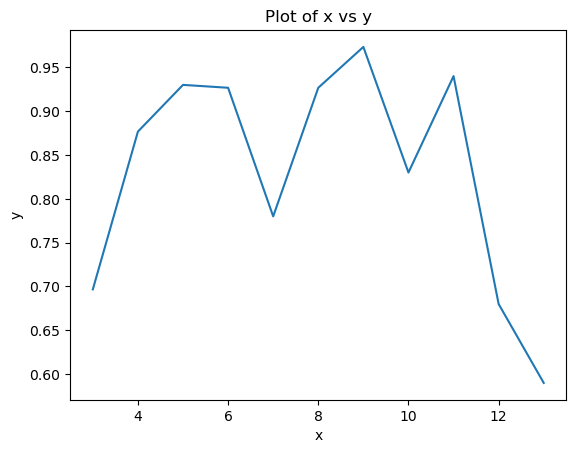

In [83]:
import matplotlib.pyplot as plt

x = [3, 4, 5, 6, 7,8,9,10,11,12,13]
y = [0.6967, 0.8767 , 0.93 , 0.9267 , 0.78 , 0.9267 , 0.9733 , 0.83 , 0.94  , 0.68 , 0.59]

plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of x vs y')
plt.show()